In [22]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    


In [31]:
SPY_Data = get1minBars('SPY_1min_data.csv')
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [4]:
# higher time frame datageneration

# Uses your adx(df, period=14) that returns ['+DI','-DI','DX','ADX'] on OHLC.
def adx(df, period: int = 14,
        high_col: str = "high", 
        low_col: str = "low", 
        close_col: str = "close"):
    """
    Returns a DataFrame with columns: +DI, -DI, DX, ADX computed with Wilder's smoothing.
    df must have High/Low/Close columns.
    """
    high, low, close = df[high_col].astype(float), df[low_col].astype(float), df[close_col].astype(float)

    # 1) True Range
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    # 2) Directional Movement
    up_move = high.diff()
    down_move = -low.diff()  # prev_low - curr_low
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)

    # 3) Wilder's smoothing (RMA) via EMA with alpha=1/period
    alpha = 1 / period
    atr        = tr.ewm(alpha=alpha, adjust=False).mean()
    plus_dm_sm = plus_dm.ewm(alpha=alpha, adjust=False).mean()
    minus_dm_sm= minus_dm.ewm(alpha=alpha, adjust=False).mean()

    # 4) DIs
    plus_di  = 100 * (plus_dm_sm / atr)
    minus_di = 100 * (minus_dm_sm / atr)

    # 5) DX
    di_sum  = (plus_di + minus_di)
    di_diff = (plus_di - minus_di).abs()
    dx = 100 * (di_diff / di_sum.replace(0, np.nan))

    # 6) ADX
    adx = dx.ewm(alpha=alpha, adjust=False).mean()

    out = pd.DataFrame({
        "+DI": plus_di,
        "-DI": minus_di,
        "DX": dx,
        "ADX": adx
    })
    return out



def adx_HTF(df):
    
    df = df.copy(deep=True)
    
    df['datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str)
    )
    
    df_1H = (
        df
        .set_index('datetime')
        .resample('60min', origin='start_day', offset='30min')
        .agg({'open':'first','high':'max','low':'min','close':'last','volume':'sum'})
        .dropna(subset=['open','high','low','close'])
        .reset_index()
    )
    
    df_1H['Date'] = df_1H['datetime'].dt.date
    df_1H['Time'] = df_1H['datetime'].dt.time
    df_1H = df_1H[['Date','Time','open','high','low','close','volume']]
   
        # df has columns: open, high, low, close, volume
    df_1H['ema20'] = df_1H['close'].ewm(span=20, adjust=False).mean().rename('EMA20').shift(1)
    df_1H['ema50'] = df_1H['close'].ewm(span=50, adjust=False).mean().rename('EMA50').shift(1)
    
    # Alignment (1 if uptrend, 0 if downtrend)
    df_1H['ema_alignment'] = (df_1H['ema20'] > df_1H['ema50']).astype(int).rename('EMA_alignment')
        
    # 2) HTF DMI/ADX
    adx_1H = adx(df_1H, period=14)
    df_1H['ADX60']  = adx_1H['ADX'].shift(1)
    df_1H['DIp60']  = adx_1H['+DI'].shift(1)
    df_1H['DIn60']  = adx_1H['-DI'].shift(1)
    df_1H['ADX60_rising3'] = (df_1H['ADX60'] > df_1H['ADX60'].shift(1)) & (df_1H['ADX60'].shift(1) > df_1H['ADX60'].shift(2))
    
    return df_1H



def true_range(df, high_col="high", low_col="low", close_col="close"):
    """
    Wilder's True Range (TR) per bar.
    TR_t = max( high_t - low_t, |high_t - close_{t-1}|, |low_t - close_{t-1}| )
    Returns a pd.Series named 'TR'.
    """
    high  = df[high_col].astype(float)
    low   = df[low_col].astype(float)
    close = df[close_col].astype(float)

    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low  - prev_close).abs()
    ], axis=1).max(axis=1)

    tr.name = "TR"
    return tr


def ATR(df, period: int = 14,
        high_col: str = "high",
        low_col: str = "low",
        close_col: str = "close",
        method: str = "wilder"):
    """
    Average True Range (ATR) over `period`.
    method='wilder' uses RMA (EMA with alpha=1/period), which is the standard.
    method='sma' uses a simple moving average.
    Returns a pd.Series named f'ATR_{period}'.
    """
    tr = true_range(df, high_col, low_col, close_col)

    if method.lower() == "wilder":
        atr = tr.ewm(alpha=1/period, adjust=False).mean()
    elif method.lower() == "sma":
        atr = tr.rolling(window=period, min_periods=period).mean()
    else:
        raise ValueError("method must be 'wilder' or 'sma'")

    atr.name = f"ATR_{period}"
    return atr


def NATR(df, period: int = 14,
         high_col: str = "high",
         low_col: str = "low",
         close_col: str = "close",
         as_percent: bool = False,
         method: str = "wilder"):
    """
    Normalized ATR = ATR / Close  (dimensionless volatility).
    If as_percent=True, returns percentage (×100).
    Returns a pd.Series named f'NATR_{period}' (or '%').
    """
    df['ATR'] = ATR(df, period, high_col, low_col, close_col, method=method)
    close = df[close_col].astype(float)

    df['NATR'] = (df['ATR'] / close).replace([np.inf, -np.inf], np.nan)
    if as_percent:
        df['NATR'] = 100.0 * df['NATR']
    
    # patching future leak
    df['ATR'] = df['ATR'].shift(1)
    df['NATR'] = df['NATR'].shift(1)
    
    # renaming a column
    df = df.rename(columns={'volume': 'volume60'})
    
    return df


# generate the HTF data
def HTF(df):
    
    df = df.copy(deep=True)
    
    # calculate ADX on higher timeframe (1h bars)
    htf = adx_HTF(df)
    
    # calculate the NATR on the HTF (1h bars)
    htf = NATR(htf)
    
    return htf

In [5]:
htf_test = HTF(SPY_Data)
htf_test

,Date,Time,open,high,low,close,volume60,ema20,ema50,ema_alignment,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR
0,2019-12-31,09:30:00,320.52,321.54,320.15,320.78,55212,NaN,NaN,0,NaN,NaN,NaN,False,NaN,NaN
1,2019-12-31,10:30:00,320.78,320.87,320.39,320.51,36136,320.780000,320.780000,0,NaN,0.000000,0.000000,False,1.390000,0.004333
2,2019-12-31,11:30:00,320.51,320.88,320.30,320.66,26634,320.754286,320.769412,0,NaN,0.000000,0.000000,False,1.325000,0.004134
3,2019-12-31,12:30:00,320.65,320.82,320.58,320.73,21344,320.745306,320.765121,0,100.000000,0.000000,0.505476,False,1.271786,0.003966
4,2019-12-31,13:30:00,320.72,321.03,320.72,321.02,26587,320.743848,320.763744,0,100.000000,0.000000,0.498243,False,1.198087,0.003735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779,2025-08-01,11:30:00,621.51,624.97,621.38,624.21,103595,632.830361,633.309401,0,25.823801,10.663527,46.998798,True,3.107280,0.005000
9780,2025-08-01,12:30:00,624.21,624.46,620.33,620.57,137281,632.009374,632.952561,0,28.047066,11.839346,43.162784,True,3.141760,0.005033
9781,2025-08-01,13:30:00,620.57,621.81,619.29,621.62,108451,630.919910,632.466971,0,30.248836,10.752101,41.533751,True,3.212348,0.005176
9782,2025-08-01,14:30:00,621.63,623.11,620.95,621.79,142412,630.034204,632.041599,0,32.426900,10.140201,41.518732,True,3.162895,0.005088


In [6]:
# get first breach out of ORB

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("9:45").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("9:45").time()]

    for _, row in intraday.iterrows():
        if row['close'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['close'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


# get the first retest after the breach
def get_first_retest(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]
    
    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= high_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= low_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
    return None

# detect confirmation bar out of ORB after retest
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeRetest = retestInfo['timeRetest'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeRetest)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
    return None



def getORB_retest_data(df):
    
    df = df.copy(deep=True)
    
    breaches = []
    for d in SPY_Data['Date'].unique():
        b = get_first_breach(SPY_Data, d)
        if b:
            breaches.append(b)
    
    breach_df = pd.DataFrame(breaches)
    breach_df
    
    
    
    retests = []
    for d in breach_df['Date'].unique():
        b = get_first_retest(SPY_Data, d, breach_df)
        if b:
            retests.append(b)
    
    retests_df = pd.DataFrame(retests)
    retests_df
    
    
    
    confirmationBars = []
    for d in retests_df['Date'].unique():
        b = detectConfirmation(SPY_Data, d, retests_df)
        if b:
            confirmationBars.append(b)
    
    confirmationBar_df = pd.DataFrame(confirmationBars)
    
    return confirmationBar_df



In [7]:
BO_and_retest = getORB_retest_data(SPY_Data)
BO_and_retest

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2019-12-31,09:47:00,high,321.34,320.15,09:50:00,15:30:00
1,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00
2,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00
3,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00
4,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00
...,...,...,...,...,...,...,...
1090,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00
1091,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00
1092,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00
1093,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00


In [8]:
def runBacktest_WithTargets(data_df, date, confirmationBar_df, TargetMultiplier = 3, slippage=0.04):

    
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]
    
    DI_plus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['+DI'].iloc[0]
    DI_minus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['-DI'].iloc[0]
    ADX = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['ADX'].iloc[0]
    vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['vwap'].iloc[0]
    prev_vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['previous_vwap'].iloc[0]
    
    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    if typeBreach == 'high':
        entryPrice = intraday.iloc[0]['open'] + slippage
    else:
        entryPrice = intraday.iloc[0]['open'] - slippage
    
    
    # initial stop
    if typeBreach == 'high':   # long
        # stopLoss = high_or - ((high_or - low_or) * 0.15)
        stopLoss = low_or
    else:   # short
        # stopLoss = low_or + ((high_or - low_or) * 0.15)
        stopLoss = high_or

    # buffer = fraction of initial risk
    initialRisk = abs(entryPrice - stopLoss)
    buffer = initialRisk

    # loop intraday
    for i in range(len(intraday) - 1):  
        row = intraday.iloc[i]
        next_row = intraday.iloc[i+1]

        if typeBreach == 'high':  # long trade


            if row['low'] <= stopLoss:  # stop triggered
                
                exitPrice, exitTime = stopLoss, row['Time']

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['high'] >= entryPrice + initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice + initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice -= slippage
                exitTime = row['Time']
                return { 'Date': date,
                         'timeBreach': signalInfo['timeBreach'].iloc[0],
                         'breach': typeBreach,
                         'OR_high': high_or,
                         'OR_low': low_or,
                         'timeRetest': timeRetest,
                         'timeConfirmationBar': timeConfirmationBar,
                         'timeExit': exitTime,
                         'entryPrice': entryPrice,
                         'exitPrice': exitPrice,
                         'returns': exitPrice - entryPrice,
                         '+DI': DI_plus,
                         '-DI': DI_minus,
                         'ADX': ADX,
                         'vwap': vwap,
                         'previous_vwap': prev_vwap }
            
            if row['high'] >= stopLoss + buffer:
                stopLoss = row['high'] - buffer


        else:  # short trade


            if row['high'] >= stopLoss:  # stop triggered
                exitPrice, exitTime = stopLoss, next_row['Time']

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= entryPrice - initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice - initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice += slippage
                exitTime = row['Time']
                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= stopLoss - buffer:
                stopLoss = row['low'] + buffer
                
    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit -= slippage
    else:
        finalExit += slippage

    return {
        'Date': date,
        'timeBreach': signalInfo['timeBreach'].iloc[0],
        'breach': typeBreach,
        'OR_high': high_or,
        'OR_low': low_or,
        'timeRetest': timeRetest,
        'timeConfirmationBar': timeConfirmationBar,
        'timeExit': finalExitTime,
        'entryPrice': entryPrice,
        'exitPrice': finalExit,
        'returns': finalExit - entryPrice if typeBreach == 'high' else entryPrice - finalExit,
        '+DI': DI_plus,
        '-DI': DI_minus,
        'ADX': ADX,
        'vwap': vwap,
        'previous_vwap': prev_vwap
    }



In [45]:
def runBacktest_WithTargets_v2(data_df, date, confirmationBar_df, TargetMultiplier = 3, slippage=0.04):

    
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]
    
    DI_plus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['+DI'].iloc[0]
    DI_minus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['-DI'].iloc[0]
    ADX = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['ADX'].iloc[0]
    vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['vwap'].iloc[0]
    prev_vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['previous_vwap'].iloc[0]
    
    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    # if typeBreach == 'high':
    #     entryPrice = intraday.iloc[0]['open'] + slippage
    # else:
    #     entryPrice = intraday.iloc[0]['open'] - slippage
    
    
    entryTargetPrice = intraday.iloc[0]['open'] - (intraday.iloc[0]['range_ma_30m'] * 0.25)

    
    
    if typeBreach == 'high':   # long
        entryTargetPrice = intraday.iloc[0]['open'] - (intraday.iloc[0]['range_ma_30m'] * 0.25)
        stopLoss = low_or # initial stop
    else:   # short
        entryTargetPrice = intraday.iloc[0]['open'] + (intraday.iloc[0]['range_ma_30m'] * 0.25)
        stopLoss = high_or

    # buffer = fraction of initial risk
    # initialRisk = abs(entryPrice - stopLoss)
    # buffer = initialRisk
    
    PositionEntered = False
    
    # loop intraday
    for i in range(len(intraday) - 1):  
        
        row = intraday.iloc[i]
        next_row = intraday.iloc[i+1]
        
        if PositionEntered is False:
            if typeBreach == 'high' and row['low'] <= entryTargetPrice:
                entryPrice = entryTargetPrice + slippage
                entryTime = row['Time']
                PositionEntered = True
                # buffer = fraction of initial risk
                initialRisk = abs(entryPrice - stopLoss)
                buffer = initialRisk
            elif typeBreach == 'low' and row['high'] >= entryTargetPrice:
                entryPrice = entryTargetPrice - slippage
                entryTime = row['Time']
                PositionEntered = True
                # buffer = fraction of initial risk
                initialRisk = abs(entryPrice - stopLoss)
                buffer = initialRisk
            else:
                continue
            
        
        if typeBreach == 'high':  # long trade


            if row['low'] <= stopLoss:  # stop triggered
                
                exitPrice, exitTime = stopLoss, row['Time']

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeEntry': entryTime,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['high'] >= entryPrice + initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice + initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice -= slippage
                exitTime = row['Time']
                return { 'Date': date,
                         'timeBreach': signalInfo['timeBreach'].iloc[0],
                         'breach': typeBreach,
                         'OR_high': high_or,
                         'OR_low': low_or,
                         'timeRetest': timeRetest,
                         'timeConfirmationBar': timeConfirmationBar,
                         'timeEntry': entryTime,
                         'timeExit': exitTime,
                         'entryPrice': entryPrice,
                         'exitPrice': exitPrice,
                         'returns': exitPrice - entryPrice,
                         '+DI': DI_plus,
                         '-DI': DI_minus,
                         'ADX': ADX,
                         'vwap': vwap,
                         'previous_vwap': prev_vwap }
            
            if row['high'] >= stopLoss + buffer:
                stopLoss = row['high'] - buffer


        else:  # short trade


            if row['high'] >= stopLoss:  # stop triggered
                exitPrice, exitTime = stopLoss, row['Time']

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeEntry': entryTime,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= entryPrice - initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice - initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice += slippage
                exitTime = row['Time']
                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeEntry': entryTime,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= stopLoss - buffer:
                stopLoss = row['low'] + buffer
                
    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit -= slippage
    else:
        finalExit += slippage
    if PositionEntered:
        return {
            'Date': date,
            'timeBreach': signalInfo['timeBreach'].iloc[0],
            'breach': typeBreach,
            'OR_high': high_or,
            'OR_low': low_or,
            'timeRetest': timeRetest,
            'timeConfirmationBar': timeConfirmationBar,
            'timeEntry': entryTime,
            'timeExit': finalExitTime,
            'entryPrice': entryPrice,
            'exitPrice': finalExit,
            'returns': finalExit - entryPrice if typeBreach == 'high' else entryPrice - finalExit,
            '+DI': DI_plus,
            '-DI': DI_minus,
            'ADX': ADX,
            'vwap': vwap,
            'previous_vwap': prev_vwap
        }
    else:
        return None


SPY_Data_VWAP = SPY_Data.copy(deep=True)

SPY_Data_VWAP['pv'] = (SPY_Data_VWAP['high'] + SPY_Data_VWAP['low'] + SPY_Data_VWAP['close']) * SPY_Data_VWAP['volume'] / 3
SPY_Data_VWAP['cum_pv'] = SPY_Data_VWAP.groupby('Date')['pv'].cumsum()
SPY_Data_VWAP['cum_vol'] = SPY_Data_VWAP.groupby('Date')['volume'].cumsum()
SPY_Data_VWAP['vwap'] = SPY_Data_VWAP['cum_pv'] / SPY_Data_VWAP['cum_vol']
previous_vwap = SPY_Data_VWAP.groupby('Date')['vwap'].last()
SPY_Data_VWAP['previous_vwap'] = SPY_Data_VWAP['Date'].map(previous_vwap.shift(1))

SPY_Data_VWAP = SPY_Data_VWAP.sort_values(['Date', 'Time']).copy()

SPY_Data_VWAP['bar_range'] = SPY_Data_VWAP['high'] - SPY_Data_VWAP['low']

SPY_Data_VWAP['range_ma_30m'] = (
    SPY_Data_VWAP
      .groupby('Date', group_keys=False)['bar_range']
      .rolling(window=30, min_periods=1)  # 30 bars = 30 minutes
      .mean()
      .reset_index(level=0, drop=True)
)
SPY_Data_VWAP['range_ma_30m'] = SPY_Data_VWAP['range_ma_30m'].shift(1)

# SPY_Data_VWAP = SPY_Data_VWAP.iloc[390:,]
# SPY_Data_VWAP


# df has columns: Date, Open, High, Low, Close, Volume
adx_df = adx(SPY_Data, period=14)
adx_df = SPY_Data_VWAP.join(adx_df)
adx_df['ADX'] = adx_df['ADX'].shift(1)


adx_df = adx_df.iloc[390:,]



# Run backtest
backtest = []
for d in BO_and_retest['Date'].unique():
    b = runBacktest_WithTargets_v2(adx_df, d, BO_and_retest)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


Total PnL: -27.831810755145113


,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeEntry,timeExit,entryPrice,exitPrice,returns,+DI,-DI,ADX,vwap,previous_vwap
0,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00,12:45:00,14:36:00,323.335167,323.664833,-0.329667,36.389123,11.188261,21.224700,323.285371,321.132256
1,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00,11:46:00,15:59:00,323.056833,322.400000,-0.656833,27.679027,13.209203,24.469975,322.502957,323.630248
2,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00,09:58:00,15:59:00,321.629018,323.630000,2.000982,22.183990,32.969274,24.218411,321.187351,322.772024
3,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00,11:14:00,15:49:00,323.594500,324.815500,1.221000,30.934500,13.796344,25.297917,323.423256,322.923538
4,2020-01-09,09:46:00,low,326.47,325.87,09:48:00,10:02:00,10:03:00,10:38:00,325.840917,326.469083,-0.628167,19.087368,23.236385,17.128724,326.100222,324.556639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00,10:00:00,10:13:00,635.084583,634.205417,-0.879167,28.687251,19.533504,26.412032,634.658527,632.050872
1051,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00,10:13:00,11:25:00,637.936333,635.775333,2.161000,21.014290,21.244910,22.842343,638.075902,636.841146
1052,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00,12:00:00,14:02:00,636.167417,636.192583,0.025167,33.638253,8.497658,31.365205,635.860109,636.097311
1053,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00,12:48:00,14:25:00,637.587667,633.632333,3.955333,16.225020,35.922195,19.319053,637.965776,634.709197


In [9]:

SPY_Data_VWAP = SPY_Data.copy(deep=True)

SPY_Data_VWAP['pv'] = (SPY_Data_VWAP['high'] + SPY_Data_VWAP['low'] + SPY_Data_VWAP['close']) * SPY_Data_VWAP['volume'] / 3
SPY_Data_VWAP['cum_pv'] = SPY_Data_VWAP.groupby('Date')['pv'].cumsum()
SPY_Data_VWAP['cum_vol'] = SPY_Data_VWAP.groupby('Date')['volume'].cumsum()
SPY_Data_VWAP['vwap'] = SPY_Data_VWAP['cum_pv'] / SPY_Data_VWAP['cum_vol']
previous_vwap = SPY_Data_VWAP.groupby('Date')['vwap'].last()
SPY_Data_VWAP['previous_vwap'] = SPY_Data_VWAP['Date'].map(previous_vwap.shift(1))

SPY_Data_VWAP = SPY_Data_VWAP.sort_values(['Date', 'Time']).copy()

SPY_Data_VWAP['bar_range'] = SPY_Data_VWAP['high'] - SPY_Data_VWAP['low']

SPY_Data_VWAP['range_ma_30m'] = (
    SPY_Data_VWAP
      .groupby('Date', group_keys=False)['bar_range']
      .rolling(window=30, min_periods=1)  # 30 bars = 30 minutes
      .mean()
      .reset_index(level=0, drop=True)
)
SPY_Data_VWAP['range_ma_30m'].shift(1)

# SPY_Data_VWAP = SPY_Data_VWAP.iloc[390:,]
# SPY_Data_VWAP




# df has columns: Date, Open, High, Low, Close, Volume
adx_df = adx(SPY_Data, period=14)
adx_df = SPY_Data_VWAP.join(adx_df)
adx_df['ADX'] = adx_df['ADX'].shift(1)


adx_df = adx_df.iloc[390:,]



# Run backtest
backtest = []
for d in BO_and_retest['Date'].unique():
    b = runBacktest_WithTargets(adx_df, d, BO_and_retest)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


Total PnL: 29.169999999977847


,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns,+DI,-DI,ADX,vwap,previous_vwap
0,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00,14:37:00,323.32,323.68,-0.36,36.389123,11.188261,21.224700,323.285371,321.132256
1,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00,15:59:00,323.08,322.40,-0.68,27.679027,13.209203,24.469975,322.502957,323.630248
2,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00,15:59:00,321.67,323.63,1.96,22.183990,32.969274,24.218411,321.187351,322.772024
3,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00,15:49:00,323.62,324.79,1.17,30.934500,13.796344,25.297917,323.423256,322.923538
4,2020-01-09,09:46:00,low,326.47,325.87,09:48:00,10:02:00,10:40:00,325.80,326.51,-0.71,19.087368,23.236385,17.128724,326.100222,324.556639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00,10:17:00,635.15,634.14,-1.01,28.687251,19.533504,26.412032,634.658527,632.050872
1090,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00,11:28:00,637.88,635.55,2.33,21.014290,21.244910,22.842343,638.075902,636.841146
1091,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00,14:02:00,636.20,636.16,-0.04,33.638253,8.497658,31.365205,635.860109,636.097311
1092,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00,14:26:00,637.55,633.67,3.88,16.225020,35.922195,19.319053,637.965776,634.709197


In [10]:
# function that helps joining the higher time frame data to the lower time frame data for when making decisions
def join_HTF_to_LTF_data(LTF, HTF):
    
    LTF = LTF.copy(deep=True)
    HTF = HTF.copy(deep=True)
    
    LTF['ts'] = pd.to_datetime(LTF['Date'].astype(str) + ' ' + LTF['timeConfirmationBar'].astype(str), errors='coerce')
    LTF['ts_30'] = (LTF['ts'] - pd.Timedelta('30min')).dt.floor('H') + pd.Timedelta('30min')
    LTF['hour_rounded_down'] = LTF['ts_30'].dt.strftime('%H:%M:%S')
    
    # temp = temp.copy(deep=True)
    
    # 1) Make Date real datetimes (same tz & day-level)
    for df in (LTF, HTF):
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None).dt.normalize()
    
    # 2) Build matching time string keys
    LTF['time_key'] = LTF['ts_30'].dt.strftime('%H:%M:%S')        # you already have ts_30
    HTF['Time_key'] = pd.to_datetime(
        HTF['Time'], format='%H:%M:%S', errors='coerce'
    ).dt.strftime('%H:%M:%S')
    
    # 3) (Optional) ensure right side is unique per key
    htf_keyed = HTF.drop_duplicates(['Date','Time_key'])
    
    # tracking column names
    LTF_columns = LTF.columns
    
    
    # 4) Merge
    LTF = LTF.merge(
        htf_keyed,
        left_on=['Date','time_key'],
        right_on=['Date','Time_key'],
        how='left',
        validate='many_to_one'
    )
    
    new_cols = ['ema20', 'ema50', 'ema_alignment','volume60','ADX60','DIp60','DIn60','ADX60_rising3','ATR','NATR']
    LTF = LTF[[*LTF_columns, *new_cols]]
    LTF = LTF.drop(columns=['ts', 'ts_30', 'hour_rounded_down'])
    
    return LTF


Number of trades:  1093
n_trades                1093.000000
win_rate                   0.395242
avg_win                    1.759514
avg_loss                  -1.137776
payoff_ratio               1.546450
expectancy_per_trade       0.007356
gross_profit             760.110000
gross_loss               752.070000
profit_factor              1.010690
total_pnl                  8.040000
median_pnl                -0.420000
max_drawdown             -73.630000
sharpe_per_trade          -0.534915
dtype: float64


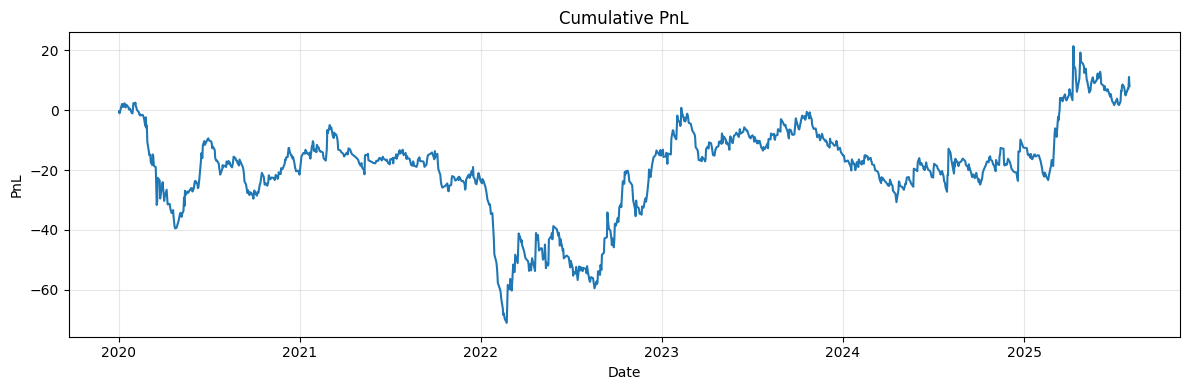

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,...,ema50,ema_alignment,volume60,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR,ORB_width
0,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00,14:37:00,323.32,323.68,...,321.098323,1,29925,94.169703,17.336585,1.138629,False,1.088863,0.003370,0.182431
1,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00,15:59:00,323.08,322.40,...,321.598776,1,42222,81.288298,19.176507,16.290885,False,1.160276,0.003596,0.573030
2,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00,15:59:00,321.67,323.63,...,321.843003,1,80736,58.381624,18.020335,19.912363,False,1.049477,0.003255,0.333999
3,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00,15:49:00,323.62,324.79,...,322.353723,1,51908,26.603792,20.851126,18.711194,False,0.899041,0.002780,0.269625
4,2020-01-09,09:46:00,low,326.47,325.87,09:48:00,10:02:00,10:40:00,325.80,326.51,...,322.879630,1,67463,25.953374,24.447575,15.537389,False,0.965456,0.002976,0.184123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00,10:17:00,635.15,634.14,...,628.011180,1,93199,27.222619,35.969261,11.672061,True,1.428511,0.002253,0.145113
1090,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00,11:28:00,637.88,635.55,...,632.756108,1,74009,32.240598,25.966579,18.964144,False,1.109081,0.001741,0.116000
1091,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00,14:02:00,636.20,636.16,...,633.664124,1,37272,19.579287,24.020484,22.175622,False,1.309101,0.002061,0.119630
1092,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00,14:26:00,637.55,633.67,...,634.359902,1,60882,16.917541,24.345256,26.954579,False,2.123122,0.003327,0.302593


In [11]:

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / (len(wins) + len(losses)))
    loss_rate = float(len(losses) / (len(wins) + len(losses)))

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats, equity, drawdown






rawBacktest = backtest_df.copy(deep=True)

rawBacktest = join_HTF_to_LTF_data(rawBacktest, htf_test)
rawBacktest = rawBacktest[rawBacktest['Date'] != datetime.date(2025, 4, 9)]
rawBacktest = rawBacktest[rawBacktest['Date'] != pd.Timestamp('2025-04-09')]
rawBacktest['ORB_width'] = (rawBacktest['OR_high'] - rawBacktest['OR_low'])/ rawBacktest['OR_low']* 100


temp = backtest_df.copy(deep=True)

temp = join_HTF_to_LTF_data(temp, htf_test)

temp = temp[temp['Date'] != datetime.date(2025, 4, 9)]
temp = temp[temp['Date'] != pd.Timestamp('2025-04-09')]


temp['ORB_width'] = (temp['OR_high'] - temp['OR_low'])/ temp['OR_low']* 100

# temp = temp[(temp['ORB_width'] > 0.15) & (temp['ORB_width'] < 0.5)]
# temp = temp[temp['ORB_width'] < 0.5]

# temp = backtest_df2[backtest_df2['timeConfirmationBar'] > dtime(15, 0)]

# temp = temp[temp['returns'] > 0]
# mask = (temp['breach'] == 'high') & (temp['+DI'] > temp['-DI']) & (temp['ADX'] > 18)
# temp['returns'] = temp['returns'].where(mask, 0) 

# print(temp['ADX'].median())

# mask = ~((temp['breach'] == 'low') & (temp['DIp60'] > temp['DIn60']) & (temp['ADX60'] < 18)) #& (temp['ADX60_rising3'] == False)
# temp['returns'] = temp['returns'].where(mask, 0) 

# temp = temp[(temp['ORB_width'] < 0.5) & (temp['ADX60'] > 18) & (((temp['DIp60'] > temp['DIn60']) & (temp['breach'] == 'high')) | ((temp['DIp60'] < temp['DIn60']) & (temp['breach'] == 'low'))) & (temp['ADX'] > 12)]

# temp = temp[(temp['ORB_width'] < 0.3) & (temp['ADX60'] > 18) & (((temp['ema20'] > temp['ema50']) & (temp['breach'] == 'high')) | ((temp['ema20'] < temp['ema50']) & (temp['breach'] == 'low'))) & (temp['ADX'] > 12) & (((temp['+DI'] > temp['-DI']) & (temp['breach'] == 'high')) | ((temp['+DI'] < temp['-DI']) & (temp['breach'] == 'low'))) & (((temp['entryPrice'] > temp['vwap']) & (temp['breach'] == 'high')) | ((temp['entryPrice'] < temp['vwap']) & (temp['breach'] == 'low')))]

# best win to dd
#[0.3, 18, None, None, None, True, 12, True, False]
# best win rate
#[0.5, 18, None, None, None, None, 20, True, False]


# mask = ~((temp['breach'] == 'high') & (temp['entryPrice'] < temp['vwap']))
# temp['returns'] = temp['returns'].where(mask, 0) 

print('Number of trades: ', temp[temp['returns']!= 0]['returns'].count())
temp['returns'] = temp['returns']# * 50 

stats, equity, dd = trade_stats(temp, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))



if 'Date' in temp.columns:
    temp['Date'] = pd.to_datetime(temp['Date'], errors='coerce')
    df = temp.sort_values('Date')

r = pd.to_numeric(df['returns'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



temp

-----------------------------------------------------------

In [23]:
def make_param_grid():
    grid = {
        # HTF regime
        'ORB_width': [None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'ADX60': [None, 12, 14, 16, 18, 20, 22, 24],
        'ADX60_rising3': [None, True, False],
        'DIp60_over_DIn60': [None, True, False],
        'NATR': [None, 0.0075, 0.010, 0.0125, 0.0150, 0.0175],
        'ema20_over_ema50': [None, True, False],
        'ADX': [None, 12, 14, 16, 18, 20, 22, 24],
        'DI+_over_DI-': [None, True, False],
        'vwap': [None, True, False],
        'excludeSide': [None, 'high', 'low'],
    }

    keys, vals = zip(*grid.items())
    combos = [dict(zip(keys, v)) for v in product(*vals)]
    return combos


def filterOutCounterParameters(df, listParams):
    ORB_width = listParams[0]
    ADX60 = listParams[1]
    ADX60_rising3 = listParams[2]
    DIp60_over_DIn60 = listParams[3]
    ema20_over_ema50 = listParams[4]
    ADX = listParams[5]
    DIp_over_DIn = listParams[6]
    vwap = listParams[7]
    excludeSide = listParams[8]

    mask = pd.Series(True, index=df.index)

    # ORB_width
    if ORB_width is not None: mask &= (df['ORB_width'] <= ORB_width)

    # ADX60
    if ADX60 is not None:
        mask &= (df['ADX60'] > ADX60)

    # ADX60 rising
    if ADX60_rising3 is not None:
        mask &= (df['ADX60_rising3'] == ADX60_rising3)

    # DIp60_over_DIn60
    if DIp60_over_DIn60 is not None:
        if DIp60_over_DIn60 == True:
            mask &= (((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] < df['DIn60']) & (df['breach'] == 'low')))
        elif DIp60_over_DIn60 == False:
            mask &= (((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] > df['DIn60']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ema20_over_ema50
    if ema20_over_ema50 is not None:
        if ema20_over_ema50 == True:
            mask &= (((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] < df['ema50']) & (df['breach'] == 'low')))
        elif ema20_over_ema50 == False:
            mask &= (((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] > df['ema50']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX is not None:
        mask &= (df['ADX'] > ADX)

    # DI+_over_DI-
    if DIp_over_DIn is not None:
        if DIp_over_DIn == True:
            mask &= (((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] < df['-DI']) & (df['breach'] == 'low')))
        elif DIp_over_DIn == False:
            mask &= (((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] > df['-DI']) & (df['breach'] == 'low')))
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap is not None:
        if vwap == True:
            mask &= (((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] > df['entryPrice']) & (df['breach'] == 'low')))
        elif vwap == False:
            mask &= (((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] < df['entryPrice']) & (df['breach'] == 'low')))
        else:
            print('error with vwap')

    if excludeSide is not None:
        if excludeSide == 'high':
            mask &= (df['breach'] != 'high')
        elif excludeSide == 'low':
            mask &= (df['breach'] != 'low')
        else:
            print('error with excludeSide')

    return df[~mask]



def filterParameters(df, listParams):
    ORB_width = listParams[0]
    ADX60 = listParams[1]
    ADX60_rising3 = listParams[2]
    DIp60_over_DIn60 = listParams[3]
    ema20_over_ema50 = listParams[4]
    ADX = listParams[5]
    DIp_over_DIn = listParams[6]
    vwap = listParams[7]
    excludeSide = listParams[8]

    mask = pd.Series(True, index=df.index)

    # ORB_width
    if ORB_width is not None: mask &= (df['ORB_width'] <= ORB_width)

    # ADX60
    if ADX60 is not None:
        mask &= (df['ADX60'] > ADX60)

    # ADX60 rising
    if ADX60_rising3 is not None:
        mask &= (df['ADX60_rising3'] == ADX60_rising3)

    # DIp60_over_DIn60
    if DIp60_over_DIn60 is not None:
        if DIp60_over_DIn60 == True:
            mask &= (((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] < df['DIn60']) & (df['breach'] == 'low')))
        elif DIp60_over_DIn60 == False:
            mask &= (((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] > df['DIn60']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ema20_over_ema50
    if ema20_over_ema50 is not None:
        if ema20_over_ema50 == True:
            mask &= (((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] < df['ema50']) & (df['breach'] == 'low')))
        elif ema20_over_ema50 == False:
            mask &= (((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] > df['ema50']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX is not None:
        mask &= (df['ADX'] > ADX)

    # DI+_over_DI-
    if DIp_over_DIn is not None:
        if DIp_over_DIn == True:
            mask &= (((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] < df['-DI']) & (df['breach'] == 'low')))
        elif DIp_over_DIn == False:
            mask &= (((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] > df['-DI']) & (df['breach'] == 'low')))
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap is not None:
        if vwap == True:
            mask &= (((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] > df['entryPrice']) & (df['breach'] == 'low')))
        elif vwap == False:
            mask &= (((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] < df['entryPrice']) & (df['breach'] == 'low')))
        else:
            print('error with vwap')

    if excludeSide is not None:
        if excludeSide == 'high':
            mask &= (df['breach'] != 'high')
        elif excludeSide == 'low':
            mask &= (df['breach'] != 'low')
        else:
            print('error with excludeSide')

    return df[mask]





def testParameters(df, bestReturns, bestWinrate, bestWinToDrawdown, ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                   ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide):
    df = df.copy(deep=True)

    df = filterParameters(df, [ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60, ema20_over_ema50, ADX,
                                         DIp_over_DIn, vwap, excludeSide])


    stats = bestReturns

    if len(df) > 250:

        stats, equity, dd = trade_stats(df, pnl_col='returns')
        # print(pd.Series(stats))

        if bestReturns == 0:
            bestReturns = stats
        if bestWinrate == 0:
            bestWinrate = stats
        if bestWinToDrawdown == 0:
            bestWinToDrawdown = stats

        if stats['total_pnl'] > bestReturns['total_pnl']:
            bestReturns = stats
            print('new bestReturns:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                   ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if stats['win_rate'] > bestWinrate['win_rate']:
            bestWinrate = stats
            print('new win_rate:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                   ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if ((stats['total_pnl'] / max(-stats['max_drawdown'], 1e-9)) > (
                bestWinToDrawdown['total_pnl'] / max(-bestWinToDrawdown['max_drawdown'], 1e-9))) & (
                stats['total_pnl'] > 0):
            bestWinToDrawdown = stats
            print('new bestWinToDrawdown:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                   ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])

    return stats, bestReturns, bestWinrate, bestWinToDrawdown





import math
import pandas as pd
import numpy as np

def run_param_search(rawBacktest, make_param_grid, min_trades=250):
    """
    Iterate over parameter combinations, filter the backtest DF, compute stats,
    and store *all* parameter + metric rows in a single DataFrame.
    """
    results = []

    for p in make_param_grid():
        # Unpack with your current names
        ORB_width          = p['ORB_width']
        ADX60              = p['ADX60']
        ADX60_rising3      = p['ADX60_rising3']
        DIp60_over_DIn60   = p['DIp60_over_DIn60']
        ema20_over_ema50   = p['ema20_over_ema50']
        ADX                 = p['ADX']
        DIp_over_DIn        = p['DI+_over_DI-']
        vwap               = p['vwap']
        excludeSide        = p['excludeSide']

        # Filter once per param set
        df_filt = filterParameters(
            rawBacktest.copy(deep=True),
            [ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
             ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide]
        )

        n = len(df_filt)
        if n <= 0:
            # # still log the attempt if you want: set metrics to NaN
            # results.append({
            #     'n_trades': n,
            #     'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            #     'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            #     'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            #     'total_pnl': np.nan, 'win_rate': np.nan, 'avg_win': np.nan, 'avg_loss': np.nan,
            #     'payoff_ratio': np.nan, 'expectancy_per_trade': np.nan, 'gross_profit': np.nan,
            #     'gross_loss': np.nan, 'profit_factor': np.nan, 'median_pnl': np.nan,
            #     'max_drawdown': np.nan, 'sharpe_per_trade': np.nan,
            #     'win_to_drawdown': np.nan, 'pf_adj': np.nan
            # })
            continue

        # Compute stats with your existing function
        stats, equity, dd = trade_stats(df_filt, pnl_col='returns')
        
        if stats.get('total_pnl', np.nan) <= 0:
            continue
        
        
        # Derived metrics that are handy to sort by
        max_dd = stats.get('max_drawdown', np.nan) or np.nan
        total_pnl = stats.get('total_pnl', np.nan) or np.nan
        if pd.notna(max_dd) and max_dd < 0:
            win_to_dd = total_pnl / abs(max_dd) if abs(max_dd) > 1e-9 else np.inf
        else:
            # if no drawdown recorded (or 0), treat very carefully
            win_to_dd = np.inf if pd.notna(total_pnl) and total_pnl > 0 else np.nan

        # A “penalized” profit factor that ignores ultra-low trade counts
        pf = stats.get('profit_factor', np.nan)
        pf_adj = pf if (pd.notna(pf) and n >= max(min_trades, 300)) else np.nan

        # Store row
        results.append({
            'n_trades': n,
            'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            'total_pnl': stats.get('total_pnl', np.nan),
            'win_rate': stats.get('win_rate', np.nan),
            'avg_win': stats.get('avg_win', np.nan),
            'avg_loss': stats.get('avg_loss', np.nan),
            'payoff_ratio': stats.get('payoff_ratio', np.nan),
            'expectancy_per_trade': stats.get('expectancy_per_trade', np.nan),
            'gross_profit': stats.get('gross_profit', np.nan),
            'gross_loss': stats.get('gross_loss', np.nan),
            'profit_factor': pf,
            'median_pnl': stats.get('median_pnl', np.nan),
            'max_drawdown': max_dd,
            'sharpe_per_trade': stats.get('sharpe_per_trade', np.nan),
            'win_to_drawdown': win_to_dd,
            'pf_adj': pf_adj
        })

    results_df = pd.DataFrame(results)

    # Optional: helpful sorts
    # Top by total_pnl
    # results_df.sort_values(['total_pnl','win_to_drawdown','n_trades'], ascending=[False, False, False], inplace=True)

    return results_df


results_df = run_param_search(rawBacktest, make_param_grid, min_trades=250)
results_df.to_excel("results.xlsx", index=False)









bestReturns = 0
bestWinrate = 0
bestWinToDrawdown = 0

for p in make_param_grid():
    stats, bestReturns, bestWinrate, bestWinToDrawdown = testParameters(rawBacktest,
                                                                        bestReturns,
                                                                        bestWinrate,
                                                                        bestWinToDrawdown,
                                                                        ORB_width=p['ORB_width'],
                                                                        ADX60=p['ADX60'],
                                                                        ADX60_rising3=p['ADX60_rising3'],
                                                                        DIp60_over_DIn60=p['DIp60_over_DIn60'],
                                                                        # NATR=p['NATR'],
                                                                        ema20_over_ema50=p['ema20_over_ema50'],
                                                                        ADX=p['ADX'],
                                                                        DIp_over_DIn=p['DI+_over_DI-'],
                                                                        vwap=p['vwap'],
                                                                        excludeSide=p['excludeSide']
                                                                        )
    # if (len(stats) > 0):
    #     print(stats['total_pnl'])
    # print(pd.Series(stats))
print('bestReturns:\n', pd.Series(bestReturns))
print('bestWinrate:\n', pd.Series(bestWinrate))
print('bestWinToDrawdown:\n', pd.Series(bestWinToDrawdown))

KeyboardInterrupt: 

-----------------------------------------------------------

In [56]:
results_df_test = results_df.copy(deep=True)
# results_df_test['']


results_df_test = results_df_test[results_df_test['n_trades'] > 40]
results_df_test = results_df_test[results_df_test['max_drawdown'] > results_df_test['max_drawdown'].median()]
results_df_test = results_df_test[results_df_test['total_pnl']*0.20 > abs(results_df_test['max_drawdown'])]
results_df_test = results_df_test[results_df_test['win_rate'] > results_df_test['win_rate'].median()]
print(results_df_test['max_drawdown'].median())
results_df_test = results_df_test.drop_duplicates()
results_df_test
# results_df_test.to_excel("results.xlsx", index=False)

-4.069999999999595


,n_trades,ORB_width,ADX60,ADX60_rising3,DIp60_over_DIn60,ema20_over_ema50,ADX,DIp_over_DIn,vwap,excludeSide,...,payoff_ratio,expectancy_per_trade,gross_profit,gross_loss,profit_factor,median_pnl,max_drawdown,sharpe_per_trade,win_to_drawdown,pf_adj
11299,57,NaN,NaN,False,True,None,24.0,True,True,low,...,2.372956,0.507895,48.81,19.86,2.457704,0.210,-4.87,2.426660,5.944559,NaN
11415,63,NaN,NaN,False,True,True,22.0,None,True,low,...,2.283482,0.479524,52.47,22.26,2.357143,0.060,-3.33,2.431194,9.072072,NaN
11431,52,NaN,NaN,False,True,True,24.0,None,True,low,...,2.453290,0.600192,47.97,16.76,2.862172,0.345,-3.33,2.756905,9.372372,NaN
11433,48,NaN,NaN,False,True,True,24.0,True,None,low,...,2.226596,0.500625,40.95,16.92,2.420213,0.275,-3.09,2.180545,7.776699,NaN
11435,47,NaN,NaN,False,True,True,24.0,True,True,low,...,2.329412,0.542128,40.95,15.47,2.647059,0.340,-2.90,2.373220,8.786207,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936242,61,0.8,24.0,False,True,True,18.0,True,None,None,...,1.622776,0.360984,46.15,24.13,1.912557,0.420,-3.64,1.881767,6.049451,NaN
936245,59,0.8,24.0,False,True,True,18.0,True,True,None,...,1.585153,0.357288,45.07,23.99,1.878699,0.420,-4.10,1.805135,5.141463,NaN
936257,64,0.8,24.0,False,True,True,20.0,None,None,None,...,1.514375,0.318750,48.88,28.48,1.716292,0.275,-4.06,1.541036,5.024631,NaN
936259,41,0.8,24.0,False,True,True,20.0,None,None,low,...,1.662014,0.461707,32.99,14.06,2.346373,0.420,-2.90,2.069916,6.527586,NaN


In [29]:
from itertools import product

def make_param_grid():
    grid = {
        # HTF regime
        'ORB_width'        : [None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'ADX60'        : [None, 12, 14, 16, 18, 20, 22, 24],
        'ADX60_rising3' : [None, True, False],
        'DIp60_over_DIn60' : [None, True, False],
        'NATR' : [None, 0.0075, 0.010, 0.0125, 0.0150, 0.0175],
        'ema20_over_ema50' : [None, True, False],
        'ADX' : [None, 12, 14, 16, 18, 20, 22, 24],
        'DI+_over_DI-' : [None, True, False],
        'vwap' : [None, True, False],
        'excludeSide' : [None, 'high', 'low'],
    }

    keys, vals = zip(*grid.items())
    combos = [dict(zip(keys, v)) for v in product(*vals)]
    return combos

In [507]:

def testParameters(df, bestReturns, bestWinrate, bestWinToDrawdown, ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide):
    df = df.copy(deep=True)

    # ORB_width
    if ORB_width != None:
        df = df[df['ORB_width'] < ORB_width]

    # ADX60
    if ADX60 != None:
        df = df[df['ADX60'] > ADX60]

    # ADX60 rising
    if ADX60_rising3 != None:
        df = df[df['ADX60_rising3'] == ADX60_rising3]

    # DIp60_over_DIn60
    if DIp60_over_DIn60 != None:
        if DIp60_over_DIn60 == True:
            df = df[((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] < df['DIn60']) & (df['breach'] == 'low'))]
        elif DIp60_over_DIn60 == False:
            df = df[((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] > df['DIn60']) & (df['breach'] == 'low'))]
        else:
            print('error with DIp60_over_DIn60')

    # # NATR
    # if NATR != None:
    #     df = df[df['NATR'] > NATR]

    # ema20_over_ema50
    if ema20_over_ema50 != None:
        if ema20_over_ema50 == True:
            df = df[((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] < df['ema50']) & (df['breach'] == 'low'))]
        elif ema20_over_ema50 == False:
            df = df[((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] > df['ema50']) & (df['breach'] == 'low'))]
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX != None:
        df = df[df['ADX'] > ADX]

    # DI+_over_DI-
    if DIp_over_DIn != None:
        if DIp_over_DIn == True:
            df = df[((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] < df['-DI']) & (df['breach'] == 'low'))]
        elif DIp_over_DIn == False:
            df = df[((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] > df['-DI']) & (df['breach'] == 'low'))]
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap != None:
        if vwap == True:
            df = df[((vwap < df['entryPrice']) & (df['breach'] == 'high')) | ((vwap > df['entryPrice']) & (df['breach'] == 'low'))]
        elif vwap == False:
            df = df[((vwap > df['entryPrice']) & (df['breach'] == 'high')) | ((vwap < df['entryPrice']) & (df['breach'] == 'low'))]
        else:
            print('error with vwap')

    
    if excludeSide != None:
        if excludeSide == 'high':
            df = df[df['breach'] != 'high']
        elif excludeSide == 'low':
            df = df[df['breach'] != 'high']
        else:
            print('error with excludeSide')
            

    stats, equity, dd = trade_stats(df, pnl_col='returns')
    # print(pd.Series(stats))
    if len(df) > 250:
        if bestReturns == 0:
            bestReturns = stats
        if bestWinrate == 0:
            bestWinrate = stats
        if bestWinToDrawdown == 0:
            bestWinToDrawdown = stats

        if stats['total_pnl'] > bestReturns['total_pnl']:
            bestReturns = stats
            print('new bestReturns:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap])
        if stats['win_rate'] > bestWinrate['win_rate']:
            bestWinrate = stats
            print('new win_rate:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap])
        if ((stats['total_pnl'] / max(-stats['max_drawdown'], 1e-9)) > (
                bestWinToDrawdown['total_pnl'] / max(-bestWinToDrawdown['max_drawdown'], 1e-9))) & (
                stats['total_pnl'] > 0):
            bestWinToDrawdown = stats
            print('new bestWinToDrawdown:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
            
            

    return stats, bestReturns, bestWinrate, bestWinToDrawdown




bestReturns = 0
bestWinrate = 0
bestWinToDrawdown = 0

for p in make_param_grid():
    stats, bestReturns, bestWinrate, bestWinToDrawdown = testParameters(rawBacktest,
                                                                        bestReturns,
                                                                        bestWinrate,
                                                                        bestWinToDrawdown,
                                                                        ORB_width=p['ORB_width'],
                                                                        ADX60=p['ADX60'],
                                                                        ADX60_rising3=p['ADX60_rising3'],
                                                                        DIp60_over_DIn60=p['DIp60_over_DIn60'],
                                                                        # NATR=p['NATR'],
                                                                        ema20_over_ema50=p['ema20_over_ema50'],
                                                                        ADX=p['ADX'],
                                                                        DIp_over_DIn=p['DI+_over_DI-'],
                                                                        vwap=p['vwap'],
                                                                        excludeSide=p['excludeSide']
                                                                        )
    # if (len(stats) > 0):
    #     print(stats['total_pnl'])
    # print(pd.Series(stats))
print('bestReturns:\n', pd.Series(bestReturns))
print('bestWinrate:\n', pd.Series(bestWinrate))
print('bestWinToDrawdown:\n', pd.Series(bestWinToDrawdown))

new bestWinToDrawdown: n_trades                535.000000
win_rate                  0.405607
avg_win                   2.058341
avg_loss                 -1.182044
payoff_ratio              1.741340
expectancy_per_trade      0.132280
gross_profit            446.660000
gross_loss              375.890000
profit_factor             1.188273
total_pnl                70.770000
median_pnl               -0.390000
max_drawdown            -33.600000
sharpe_per_trade          0.930910
dtype: float64
[None, None, None, None, <function NATR at 0x0000020802EB01F0>, None, None, None, None, 'high']
new win_rate: n_trades                558.000000
win_rate                  0.410394
avg_win                   1.629039
avg_loss                 -1.083587
payoff_ratio              1.503377
expectancy_per_trade      0.029659
gross_profit            373.050000
gross_loss              356.500000
profit_factor             1.046424
total_pnl                16.550000
median_pnl               -0.340000
max_drawdown

KeyboardInterrupt: 

In [31]:
from itertools import product

def make_Counterparam_grid():
    grid = {
        # HTF regime
        'ORB_width'        : [ 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'ADX60'        : [ 12, 14, 16, 18, 20, 22, 24],
        'ADX60_rising3' : [None, True, False],
        'DIp60_over_DIn60' : [None, True, False],
        'NATR' : [ 0.0075, 0.010, 0.0125, 0.0150, 0.0175],
        'ema20_over_ema50' : [None, True, False],
        'ADX' : [12, 14, 16, 18, 20, 22, 24],
        'DI+_over_DI-' : [None, True, False],
        'vwap' : [None, True, False],
        'excludeSide' : [None, 'high', 'low'],
    }

    keys, vals = zip(*grid.items())
    combos = [dict(zip(keys, v)) for v in product(*vals)]
    return combos

In [505]:

def testCounterParameters(df, worstReturns, worstWinrate, worstWinToDrawdown, ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide):
    df = df.copy(deep=True)

    # ORB_width
    if ORB_width != None:
        df = df[df['ORB_width'] > ORB_width]

    # ADX60
    if ADX60 != None:
        df = df[df['ADX60'] < ADX60]

    # ADX60 rising
    if ADX60_rising3 != None:
        df = df[df['ADX60_rising3'] == ADX60_rising3]

    # DIp60_over_DIn60
    if DIp60_over_DIn60 != None:
        if DIp60_over_DIn60 == True:
            df = df[((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] < df['DIn60']) & (df['breach'] == 'low'))]
        elif DIp60_over_DIn60 == False:
            df = df[((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] > df['DIn60']) & (df['breach'] == 'low'))]
        else:
            print('error with DIp60_over_DIn60')

    # # NATR
    # if NATR != None:
    #     df = df[df['NATR'] > NATR]

    # ema20_over_ema50
    if ema20_over_ema50 != None:
        if ema20_over_ema50 == True:
            df = df[((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] < df['ema50']) & (df['breach'] == 'low'))]
        elif ema20_over_ema50 == False:
            df = df[((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] > df['ema50']) & (df['breach'] == 'low'))]
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX != None:
        df = df[df['ADX'] < ADX]

    # DI+_over_DI-
    if DIp_over_DIn != None:
        if DIp_over_DIn == True:
            df = df[((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] < df['-DI']) & (df['breach'] == 'low'))]
        elif DIp_over_DIn == False:
            df = df[((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] > df['-DI']) & (df['breach'] == 'low'))]
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap != None:
        if vwap == True:
            df = df[((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | ((df['vwap'] > df['entryPrice']) & (df['breach'] == 'low'))]
        elif vwap == False:
            df = df[((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | ((df['vwap'] < df['entryPrice']) & (df['breach'] == 'low'))]
        else:
            print('error with vwap')

    
    if excludeSide != None:
        if excludeSide == 'high':
            df = df[df['breach'] != 'high']
        elif excludeSide == 'low':
            df = df[df['breach'] != 'low']
        else:
            print('error with excludeSide')
            
    stats = worstReturns        
    if len(df) > 150:
        stats, equity, dd = trade_stats(df, pnl_col='returns')
        # print(pd.Series(stats))
    
        if worstReturns == 0:
            worstReturns = stats
        if worstWinrate == 0:
            worstWinrate = stats
        if worstWinToDrawdown == 0:
            worstWinToDrawdown = stats

        if stats['total_pnl'] < worstReturns['total_pnl']:
            worstReturns = stats
            print('new worst Returns:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if stats['win_rate'] < worstWinrate['win_rate']:
            worstWinrate = stats
            print('new worst win_rate:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if ((stats['total_pnl'] / max(-stats['max_drawdown'], 1e-9)) < (
                worstWinToDrawdown['total_pnl'] / max(-worstWinToDrawdown['max_drawdown'], 1e-9))) & (
                stats['total_pnl'] > 0):
            worstWinToDrawdown = stats
            print('new best WinToDrawdown:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
            
            

    return stats, worstReturns, worstWinrate, worstWinToDrawdown




worstReturns = 0
worstWinrate = 0
worstWinToDrawdown = 0

for p in make_Counterparam_grid():
    stats, worstReturns, worstWinrate, worstWinToDrawdown = testCounterParameters(rawBacktest,
                                                                        worstReturns,
                                                                        worstWinrate,
                                                                        worstWinToDrawdown,
                                                                        ORB_width=p['ORB_width'],
                                                                        ADX60=p['ADX60'],
                                                                        ADX60_rising3=p['ADX60_rising3'],
                                                                        DIp60_over_DIn60=p['DIp60_over_DIn60'],
                                                                        # NATR=p['NATR'],
                                                                        ema20_over_ema50=p['ema20_over_ema50'],
                                                                        ADX=p['ADX'],
                                                                        DIp_over_DIn=p['DI+_over_DI-'],
                                                                        vwap=p['vwap'],
                                                                        excludeSide=p['excludeSide']
                                                                        )
    # if (len(stats) > 0):
    #     print(stats['total_pnl'])
    # print(pd.Series(stats))
print('worstReturns:\n', pd.Series(worstReturns))
print('worstWinrate:\n', pd.Series(worstWinrate))
print('worstWinToDrawdown:\n', pd.Series(worstWinToDrawdown))


KeyboardInterrupt



In [51]:

def testCounterParameters(df, worstReturns, worstWinrate, worstWinToDrawdown, ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide):
    df = df.copy(deep=True)

    df = filterOutCounterParameters(df, [ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60, ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
            
    stats = worstReturns        
    if len(df) > 150:
        stats, equity, dd = trade_stats(df, pnl_col='returns')
        # print(pd.Series(stats))
    
        if worstReturns == 0:
            worstReturns = stats
        if worstWinrate == 0:
            worstWinrate = stats
        if worstWinToDrawdown == 0:
            worstWinToDrawdown = stats

        if stats['total_pnl'] < worstReturns['total_pnl']:
            worstReturns = stats
            print('new worst Returns:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if stats['win_rate'] < worstWinrate['win_rate']:
            worstWinrate = stats
            print('new worst win_rate:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
        if ((stats['total_pnl'] / max(-stats['max_drawdown'], 1e-9)) < (
                worstWinToDrawdown['total_pnl'] / max(-worstWinToDrawdown['max_drawdown'], 1e-9))) & (
                stats['total_pnl'] > 0):
            worstWinToDrawdown = stats
            print('new best WinToDrawdown:', pd.Series(stats))
            print([ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
                    ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide])
            
            

    return stats, worstReturns, worstWinrate, worstWinToDrawdown




worstReturns = 0
worstWinrate = 0
worstWinToDrawdown = 0

for p in make_Counterparam_grid():
    stats, worstReturns, worstWinrate, worstWinToDrawdown = testCounterParameters(rawBacktest,
                                                                        worstReturns,
                                                                        worstWinrate,
                                                                        worstWinToDrawdown,
                                                                        ORB_width=p['ORB_width'],
                                                                        ADX60=p['ADX60'],
                                                                        ADX60_rising3=p['ADX60_rising3'],
                                                                        DIp60_over_DIn60=p['DIp60_over_DIn60'],
                                                                        # NATR=p['NATR'],
                                                                        ema20_over_ema50=p['ema20_over_ema50'],
                                                                        ADX=p['ADX'],
                                                                        DIp_over_DIn=p['DI+_over_DI-'],
                                                                        vwap=p['vwap'],
                                                                        excludeSide=p['excludeSide']
                                                                        )
    # if (len(stats) > 0):
    #     print(stats['total_pnl'])
    # print(pd.Series(stats))
print('worstReturns:\n', pd.Series(worstReturns))
print('worstWinrate:\n', pd.Series(worstWinrate))
print('worstWinToDrawdown:\n', pd.Series(worstWinToDrawdown))

new worst Returns: n_trades                775.000000
win_rate                  0.358710
avg_win                   1.794979
avg_loss                 -1.213618
payoff_ratio              1.479032
expectancy_per_trade     -0.134405
gross_profit            499.004271
gross_loss              603.168172
profit_factor             0.827305
total_pnl              -104.163902
median_pnl               -0.510500
max_drawdown           -123.934947
sharpe_per_trade         -2.379977
dtype: float64
[0.3, 12, None, None, None, 12, None, None, 'low']
new worst win_rate: n_trades                775.000000
win_rate                  0.358710
avg_win                   1.794979
avg_loss                 -1.213618
payoff_ratio              1.479032
expectancy_per_trade     -0.134405
gross_profit            499.004271
gross_loss              603.168172
profit_factor             0.827305
total_pnl              -104.163902
median_pnl               -0.510500
max_drawdown           -123.934947
sharpe_per_trade    


KeyboardInterrupt



n_trades                175.000000
win_rate                  0.491429
avg_win                   1.408907
avg_loss                 -0.697848
payoff_ratio              2.018932
expectancy_per_trade      0.337472
gross_profit            121.166016
gross_loss               62.108444
profit_factor             1.950878
total_pnl                59.057571
median_pnl               -0.055167
max_drawdown             -8.631458
sharpe_per_trade          3.009005
dtype: float64


C:\Users\JayCo\AppData\Local\Temp\ipykernel_5204\215169675.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_filtered['Date'] = pd.to_datetime(backtest_filtered['Date'], errors='coerce')


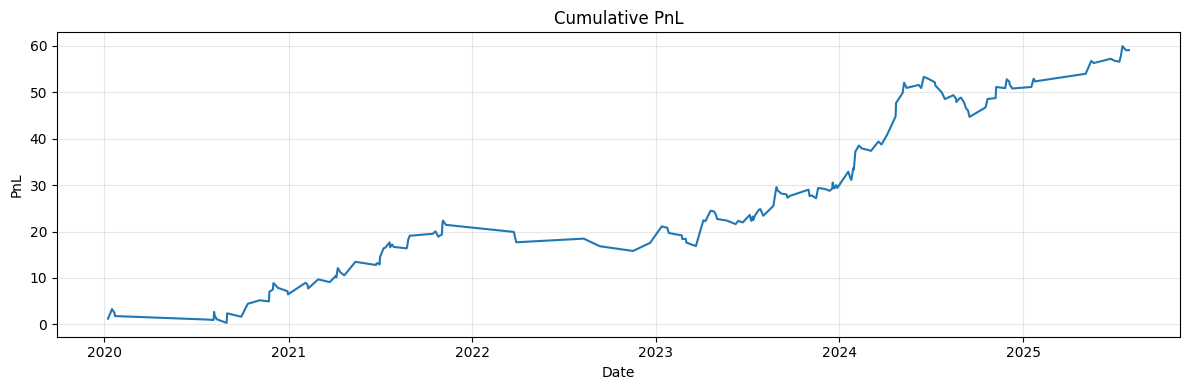

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeEntry,timeExit,entryPrice,...,ema50,ema_alignment,volume60,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR,ORB_width
3,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00,11:14:00,15:49:00,323.594500,...,322.353723,1,51908,26.603792,20.851126,18.711194,False,0.899041,0.002780,0.269625
6,2020-01-13,09:56:00,high,326.56,325.92,10:05:00,10:25:00,10:26:00,15:59:00,326.645750,...,324.364549,1,56851,22.940106,20.582413,24.614807,False,0.796782,0.002446,0.196367
9,2020-01-16,13:36:00,high,329.99,329.54,14:04:00,14:05:00,14:34:00,15:59:00,330.038667,...,326.867556,1,29008,18.182185,28.456936,16.264270,True,0.808368,0.002450,0.136554
10,2020-01-21,11:13:00,high,331.56,330.86,13:20:00,13:25:00,13:26:00,14:01:00,331.661083,...,328.726931,1,41826,30.243327,31.679922,16.576277,False,0.665832,0.002006,0.211570
11,2020-01-22,09:49:00,high,332.72,332.00,10:29:00,10:37:00,10:38:00,11:07:00,332.788667,...,329.264133,1,51059,25.899763,31.204085,16.990747,False,0.746818,0.002245,0.216867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2025-07-11,10:14:00,high,623.52,621.69,10:48:00,10:49:00,10:50:00,15:59:00,623.793833,...,620.584822,1,57959,21.902099,23.443010,30.045528,False,1.644612,0.002636,0.294359
1042,2025-07-14,09:51:00,high,623.35,621.79,10:25:00,10:58:00,10:59:00,15:59:00,623.428167,...,621.372842,1,58703,18.526511,16.388058,29.101967,False,1.554269,0.002496,0.250889
1045,2025-07-17,09:49:00,high,625.64,624.18,09:59:00,10:00:00,10:07:00,15:59:00,625.868833,...,622.637719,1,82535,19.614901,18.731892,26.074741,False,1.768276,0.002833,0.233907
1050,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00,10:00:00,10:13:00,635.084583,...,628.011180,1,93199,27.222619,35.969261,11.672061,True,1.428511,0.002253,0.145113


In [53]:
def filterOutCounterParameters(df, listParams):


    ORB_width = listParams[0]
    ADX60 = listParams[1]
    ADX60_rising3 = listParams[2]
    DIp60_over_DIn60 = listParams[3]
    ema20_over_ema50 = listParams[4]
    ADX = listParams[5]
    DIp_over_DIn = listParams[6]
    vwap = listParams[7]
    excludeSide = listParams[8]



    mask = pd.Series(True, index=df.index)
    
    # ORB_width
    if ORB_width is not None: mask &= (df['ORB_width'] <= ORB_width)
    
    
    # ADX60
    if ADX60 is not None:
       mask &= (df['ADX60'] > ADX60)
    
    
    
    # ADX60 rising
    if ADX60_rising3 is not None:
         mask &= (df['ADX60_rising3'] == ADX60_rising3)

    # DIp60_over_DIn60
    if DIp60_over_DIn60 is not None:
        if DIp60_over_DIn60 == True:
            mask &= (((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] < df['DIn60']) & (df['breach'] == 'low')))
        elif DIp60_over_DIn60 == False:
            mask &= (((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | ((df['DIp60'] > df['DIn60']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')



    # ema20_over_ema50
    if ema20_over_ema50 is not None:
        if ema20_over_ema50 == True:
            mask &= (((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] < df['ema50']) & (df['breach'] == 'low')))
        elif ema20_over_ema50 == False:
            mask &= (((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | ((df['ema20'] > df['ema50']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX is not None:
        mask &= (df['ADX'] > ADX)

    # DI+_over_DI-
    if DIp_over_DIn is not None:
        if DIp_over_DIn == True:
            mask &=(((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] < df['-DI']) & (df['breach'] == 'low')))
        elif DIp_over_DIn == False:
            mask &=(((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | ((df['+DI'] > df['-DI']) & (df['breach'] == 'low')))
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap is not None:
        if vwap == True:
            mask &=(((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | ((df['vwap'] > df['entryPrice']) & (df['breach'] == 'low')))
        elif vwap == False:
            mask &=(((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | ((df['vwap'] < df['entryPrice']) & (df['breach'] == 'low')))
        else:
            print('error with vwap')

    
    if excludeSide is not None:
        if excludeSide == 'high':
            mask &=(df['breach'] != 'high')
        elif excludeSide == 'low':
            mask &=(df['breach'] != 'low')
        else:
            print('error with excludeSide')
            
            
    return df[mask]
    


backtest_filtered = rawBacktest
backtest_filtered = filterOutCounterParameters(rawBacktest, [0.3, 18, None, None, None, 14, None, True, 'low'])
# backtest_filtered = filterOutCounterParameters(backtest_filtered, [0.6, 12, None, None, None, 12, None, True, None])
# backtest_filtered = filterOutCounterParameters(backtest_filtered, [0.8, 14, None, None, None, 12, None, None, None])


stats, equity, dd = trade_stats(backtest_filtered, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))



if 'Date' in temp.columns:
    backtest_filtered['Date'] = pd.to_datetime(backtest_filtered['Date'], errors='coerce')
    df = backtest_filtered.sort_values('Date')

r = pd.to_numeric(df['returns'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



backtest_filtered

In [48]:
worstReturns = 0
worstWinrate = 0
worstWinToDrawdown = 0


for p in make_Counterparam_grid():
    stats, worstReturns, worstWinrate, worstWinToDrawdown = testCounterParameters(backtest_filtered,
                                                                        worstReturns,
                                                                        worstWinrate,
                                                                        worstWinToDrawdown,
                                                                        ORB_width=p['ORB_width'],
                                                                        ADX60=p['ADX60'],
                                                                        ADX60_rising3=p['ADX60_rising3'],
                                                                        DIp60_over_DIn60=p['DIp60_over_DIn60'],
                                                                        # NATR=p['NATR'],
                                                                        ema20_over_ema50=p['ema20_over_ema50'],
                                                                        ADX=p['ADX'],
                                                                        DIp_over_DIn=p['DI+_over_DI-'],
                                                                        vwap=p['vwap'],
                                                                        excludeSide=p['excludeSide']
                                                                        )
    # if (len(stats) > 0):
    #     print(stats['total_pnl'])
    # print(pd.Series(stats))
print('worstReturns:\n', pd.Series(worstReturns))
print('worstWinrate:\n', pd.Series(worstWinrate))
print('worstWinToDrawdown:\n', pd.Series(worstWinToDrawdown))

NameError: name 'backtest_filtered' is not defined